In [1]:
from random import sample, seed
import numpy as np 
import pandas as pd

#utility functions : prepare the data 
from model_fp_selection.lib.utils import get_morgan_fp, get_rdkit_fp, convert_to_float
from model_fp_selection.lib.utils import prepare_df_morgan, prepare_df_rdkit, swap_identical_ligands
from model_fp_selection.lib.utils import drop_duplicates, average_duplicates, calc_desc, get_rdkit_descriptors

# RDkit
from rdkit import Chem, RDLogger
from rdkit.Chem import AllChem, DataStructs, Draw, rdMolDescriptors, Descriptors
from rdkit.Chem.Scaffolds import MurckoScaffold
from rdkit.Chem.rdDepictor import Compute2DCoords

# Visualization
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 20})

import mols2grid
import requests
import os


np.bool = np.bool_ # Required to avoid an error when running the model

# Combinatorial library generation
import itertools
from itertools import combinations_with_replacement

from tqdm.auto import tqdm
import time

np.random.seed(42)
seed(42)

RDLogger.DisableLog('rdApp.*')

# Murcko Decomposition

#### Preparing the dataset

In [4]:
metals= pd.read_csv("ruthenium_complexes_dataset.csv", dtype={'L1': str, 'L2': str, 'L3': str})
metals_rdkit = prepare_df_rdkit(metals)

In [5]:
metals_rdkit = average_duplicates(metals_rdkit, 'Ligands_Dict', 'pIC50')

Length of training dataset after cleaning duplicates, before adding permutations : 718


Let's have a look at the third ligand L3. We sort the dataframe by pIC50 value and display the L3 ligand as well as pIC50.

In [6]:
df_sorted = metals_rdkit.sort_values(by=['pIC50'], ascending = False)

In [7]:
df_sorted['mol3'] = df_sorted['L3'].apply(Chem.MolFromSmiles)
df_sorted['SMILES'] = df_sorted['L3']

In [8]:
mols2grid.display(df_sorted, subset = ['img', 'pIC50'])

#### Extracting the generic scaffolds

There are many ways to extract scaffolds, but the simplest and most chemically relevant - in our opinion - is the MurckoScaffold.GetScaffoldForMol function, which outputs the "generic framework". First we create a dataframe of every unique ligand and compute their scaffold.

In [9]:
all_ligands = pd.concat([metals_rdkit['L1'], metals_rdkit['L2'], metals_rdkit['L3']])
ligands = pd.DataFrame(all_ligands.unique(), columns=['SMILES']) # We create a data frame of every unique ligand in the dataset

In [10]:
mols2grid.display(ligands)

In [11]:
ligands['mol'] = ligands['SMILES'].apply(Chem.MolFromSmiles)
ligands['Scaffold'] = ligands['mol'].apply(MurckoScaffold.GetScaffoldForMol) # We add two columns, calling the two rdkit functions for scaffold identification

In [12]:
# We extract the scaffolds columns 
scaffolds = pd.DataFrame(ligands['Scaffold'].drop_duplicates())
scaffolds = scaffolds.rename(columns={'Scaffold': 'mol'}) 

In [13]:
# Re-compute the SMILES
scaffolds['SMILES'] = scaffolds['mol'].apply(Chem.MolToSmiles)

Now we create a dictionary to count the occurence of each scaffold.

In [14]:
scaffolds['occurences'] = 0 # We create a numerical column to count the occurences of each ligand.
scaffolds_occurence_dict = dict(zip(scaffolds['SMILES'], scaffolds['occurences']))

In [15]:
for l1 in ligands['Scaffold']:    # We count the occurence of each scaffold
    l1 = Chem.MolToSmiles(l1)
    scaffolds_occurence_dict[l1] += 1

In [16]:
sorted_scaffolds_dict = sorted(scaffolds_occurence_dict.items(), key=lambda x: x[1], reverse=True)    # We sort scaffolds by occurence

We will now display the scaffolds sorted by frequency in a grid.

In [17]:
scaffold_grid_dict = dict() # We create a new dictionary with scaffolds sorted by occurence
scaffold_grid_dict['SMILES'] = [x[0] for x in sorted_scaffolds_dict]
scaffold_grid_dict['occurences'] = [x[1] for x in sorted_scaffolds_dict]
scaffold_grid_dict['molecules'] = [Chem.MolFromSmiles(x[0]) for x in sorted_scaffolds_dict]

mols2grid.display(scaffold_grid_dict, subset=["img","occurences"], substruct_highlight=True)

A useful tool would be a table that associates a ligand with a DOI, so that we can easily find the paper a specific framework stems from using SMARTS queries.

In [18]:
# Reshape the DataFrame using melt
melted_df = pd.melt(metals_rdkit, id_vars='DOI', value_vars=['L1', 'L2', 'L3'], var_name='SMILES')

# Concatenate SMILES columns
concatenated_smiles = melted_df['value']

# Create a new DataFrame with concatenated SMILES and corresponding DOIs
ligand_DOI = pd.DataFrame({'SMILES': concatenated_smiles, 'DOI': melted_df['DOI']})

mols2grid.display(ligand_DOI, subset=['DOI'])

# PubChem Library Generation

PubChem database (https://pubchem.ncbi.nlm.nih.gov/) allows to download data in CSV format. We downloaded several molecules ensembles based on the top 25 scaffolds found in the dataset. Among these molecules are salts, complexes, etc. that we want to get rid of. To do so, we implement a loop to read each CSV file and copy only the rows where the SMILES does not include a dot.

In [9]:
### THIS CELL DOWNLOADS THE PUBCHEM CSV FILES FROM FIGSHARE

from pathlib import Path
import requests

ARTICLE_ID = 31264441  
TARGET_PREFIX = "PubChem"

BASE_DIR = Path("./data/pubchem")
BASE_DIR.mkdir(exist_ok=True)

api_url = f"https://api.figshare.com/v2/articles/{ARTICLE_ID}"
response = requests.get(api_url)
response.raise_for_status()
article = response.json()

for file_info in article["files"]:
    filename = file_info["name"]

    if filename.startswith(TARGET_PREFIX):
        download_url = file_info["download_url"]

        local_path = BASE_DIR / filename
        local_path.parent.mkdir(parents=True, exist_ok=True)

        if local_path.exists():
            print(f"Skipping existing file: {filename}")
            continue

        print(f"Downloading: {filename}")
        with requests.get(download_url, stream=True) as r:
            r.raise_for_status()
            with open(local_path, "wb") as f:
                for chunk in r.iter_content(chunk_size=8192):
                    f.write(chunk)

print("Done.")

Downloading: PubChem_compound_smiles_substructure_c1ccc[n]c1-c2[n]cccc2.csv


KeyboardInterrupt: 

In [19]:
directory = "./data/pubchem"

file_list = os.listdir(directory)

df_list=[]

for file in file_list:
    file_path = os.path.join(directory, file)
    df=pd.read_csv(file_path, on_bad_lines='warn', low_memory=False)
    filtered_df = df[~df['isosmiles'].str.contains('\.')] # Copy only the entries where the SMILES have no dot(s)
    df_list.append(filtered_df)

pubchem_ligands = pd.concat(df_list, ignore_index=True)

In [20]:
pubchem_ligands=pubchem_ligands.rename(columns={'isosmiles':'SMILES'})

We delete rows where there is no SMILES as well as duplicates.

In [21]:
pubchem_ligands.dropna(subset=['SMILES'], how='any', inplace=True)
pubchem_ligands.drop_duplicates(subset='SMILES', keep='first', inplace=True)

In [22]:
len(pubchem_ligands.SMILES)

486750

Now we get rid of everything but the SMILES :

In [23]:
pubchem_ligands=pubchem_ligands[['SMILES']]
pubchem_ligands.reset_index(drop=True, inplace=True)

In order to process the data, we can add a canonical SMILES column and compute the mol objects for each ligand.

In [24]:
pubchem_ligands['canon_SMILES'] = 0
pubchem_ligands['mol'] = 0

for i in range(len(pubchem_ligands['SMILES'])):
    smiles = pubchem_ligands['SMILES'][i]
    pubchem_ligands.at[i, 'mol'] = Chem.MolFromSmiles(smiles)
    mol = pubchem_ligands['mol'][i]
    if mol:
        # To obtain canonical SMILES we calculate the mol object and convert it back to SMILES
        pubchem_ligands.at[i, 'canon_SMILES']=Chem.MolToSmiles(mol) 

C:\Users\bparm\AppData\Local\Temp\ipykernel_6572\3760555192.py:6: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '<rdkit.Chem.rdchem.Mol object at 0x000002B526EFD5B0>' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pubchem_ligands.at[i, 'mol'] = Chem.MolFromSmiles(smiles)
C:\Users\bparm\AppData\Local\Temp\ipykernel_6572\3760555192.py:10: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'CC(C)n1nccc1-c1ncccc1COc1cccc(O)c1C=O' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  pubchem_ligands.at[i, 'canon_SMILES']=Chem.MolToSmiles(mol)


## Selection process

We want to generate realistic compounds. The vast majority of examples from the literature include 'AAB'-type compounds : two "generic" ligands (A), often nitrogen-based, and one "specific" ligand (B) of more flexible nature. 
We choose to focus on bipyridine and phenanthroline derivatives for the generic ligands, and we identify three more specific scaffolds that are frequently represented in our dataset.

We do not want to select bipy-based or phen-based ligands that are substituted by more than a methyl on the ortho 
carbon (with respect to the nitrogen atom). We modify the queries and selection loops accordingly (addition of "dime" and "me" queries).

In [25]:
authorized_elements = [1, 6, 7, 8, 9, 15, 16, 17, 35, 53]

def elements(mol):
    """
    This function ensures every molecule contains only 'authorized' atoms (to avoid ulterior errors and keep it simple) : H, C, N, O, S, P, halogens... 
    It also ensures each ligand is constituted of 4 heavy atoms at least and that its molecular weight never exceeds 1000 g/mol.
    """
    include=True
    if mol.GetNumHeavyAtoms() <= 4: 
        include = False
    if Descriptors.ExactMolWt(mol) > 1000:
        include = False
    for atom in mol.GetAtoms():
        num = atom.GetAtomicNum()
        if num not in authorized_elements:
            include = False
    return include

In [26]:
def deprotonate_protonated_nitrogen(mol):
    """
    Deprotonate protonated nitrogen atoms (R2NH+ or RNH2+) and set them to neutral.
    """
    # SMARTS patterns for protonated nitrogen
    r2nh_pattern = Chem.MolFromSmarts('[N+H]')  # R2NH+
    rnh2_pattern = Chem.MolFromSmarts('[N+H2]')        # RNH2+
    
    # Replacement fragments for deprotonated nitrogen
    r2n_replacement = Chem.MolFromSmiles('[N]')  # R2N
    rnh_replacement = Chem.MolFromSmiles('[NH]')        # RNH

    # Replace protonated R2NH+ with R2N
    while mol.HasSubstructMatch(r2nh_pattern):
        mol = Chem.ReplaceSubstructs(mol, r2nh_pattern, r2n_replacement, replaceAll=False)[0]
    
    # Replace protonated RNH2+ with RNH
    while mol.HasSubstructMatch(rnh2_pattern):
        mol = Chem.ReplaceSubstructs(mol, rnh2_pattern, rnh_replacement, replaceAll=False)[0]

    mol = Chem.MolFromSmiles(Chem.MolToSmiles(mol))

    return mol

In [27]:
def remove_isotope(mol):
    """
    If a molecule contains a specific isotope (e.g. deuterium) this function replaces it by the most common isotope of the element (e.g. hydrogen).
    """
    for atom in mol.GetAtoms():
        if atom.GetIsotope() != 0:
            atom.SetIsotope(0)
    return mol

In [28]:
#SMARTS queries for unsubstituted and methylated bipyridine :
bipy = Chem.MolFromSmarts('c1cc[cH][n]c1-c2[n][cH]ccc2')
dimebipy = Chem.MolFromSmarts('c1ccc([CH3])[n]c1-c2[n]c([CH3])ccc2')

#SMARTS queries for unsubstituted and methylated phenanthroline :
phen= Chem.MolFromSmarts('c1[cH][n]c2c(c1)ccc1cc[cH][n]c12')
dimephen= Chem.MolFromSmarts('c1c([CH3])[n]c2c(c1)ccc1ccc([CH3])[n]c12')

nitrogen = [bipy, dimebipy, phen, dimephen]
mols2grid.display(nitrogen)

In [29]:
#SMARTS queries to exclude, in order to ensure the coordination sites are free

monoox = Chem.MolFromSmarts('c1cc[cH][n+]c1-c2[n][cH]ccc2')
diox = Chem.MolFromSmarts('c1cc[cH][n+]c1-c2[n+][cH]ccc2')

bad_nitrogen = [monoox, diox]
mols2grid.display(bad_nitrogen)

Then we can define a function that iterates on the SMILES to select ligands matching the queries above :

In [30]:
def getdf_nitrogen(canon_SMILES, emol = False):
    
    nitrogen = []
    
    if emol == True: # If the dataset we filter comes from the eMolecules database ; in this case we also add the Suppliers column
        nitrogen = []
        for index, row in canon_SMILES.iterrows() :
            smiles=str(row['SMILES'])
            mol=Chem.MolFromSmiles(smiles)
            suppliers=row['SUPPLIER_NAME']
            if mol and elements(mol):
                if ((mol.HasSubstructMatch(bipy) or mol.HasSubstructMatch(phen) or mol.HasSubstructMatch(dimebipy) or mol.HasSubstructMatch(dimephen)) 
                    and not any(mol.HasSubstructMatch(sub) for sub in bad_nitrogen)):
                    mol = deprotonate_protonated_nitrogen(mol)
                    mol = remove_isotope(mol)
                    smiles = Chem.MolToSmiles(mol)
                    mol = Chem.MolFromSmiles(smiles)
                    nitrogen.append({'SMILES' : smiles, 'mol' : mol, 'Suppliers' : suppliers})
        return pd.DataFrame(nitrogen)
    
    else : # If the dataset comes from PubChem of Scifinder we just filter the ligands
        for smiles in canon_SMILES :
            smiles=str(smiles)
            mol=Chem.MolFromSmiles(smiles)
            if mol and elements(mol):
                if ((mol.HasSubstructMatch(bipy) or mol.HasSubstructMatch(phen) or mol.HasSubstructMatch(dimebipy) or mol.HasSubstructMatch(dimephen)) 
                    and not any(mol.HasSubstructMatch(sub) for sub in bad_nitrogen)):
                    mol = deprotonate_protonated_nitrogen(mol)
                    mol = remove_isotope(mol)
                    smiles = Chem.MolToSmiles(mol)
                    mol = Chem.MolFromSmiles(smiles)
                    nitrogen.append({'SMILES' : smiles, 'mol' : mol})

        return pd.DataFrame(nitrogen)

In [31]:
nitrogen_ligands_pubchem = getdf_nitrogen(pubchem_ligands.canon_SMILES)
#nitrogen_ligands_pubchem.to_csv('../nitrogen_ligands_pubchem_new.csv')  # uncomment if you want to save the file

In [32]:
len(nitrogen_ligands_pubchem)

25834

Same for generic ligands :

In [33]:
# SMARTS query for quinoleine framework
quinoleine = Chem.MolFromSmarts('c1cc2c(c([OH])[cH]1)[n][cH]cc2')
dimequinoleine = Chem.MolFromSmarts('c1cc2c(c([OH])c([CH3])1)[n]c([CH3])cc2')

# SMARTS query for dipyridylamine framework
dipyamine = Chem.MolFromSmarts('c1ccc(Nc2ccc[cH]n2)n[cH]1')
dimedipyamine = Chem.MolFromSmarts('c1ccc(Nc2cccc([CH3])n2)nc([CH3])1')

# SMARTS query for 3-[(Z)-benzylideneamino]-2-phenylquinazolin-4-one framework
framework3 = Chem.MolFromSmarts('O=c1n(N=C)cnc2ccc[cH]c21')
meframework3 = Chem.MolFromSmarts('O=c1n(N=C)cnc2cccc([CH3])c21')

framework4 = Chem.MolFromSmarts('c1(C2=NNC=C2)n[cH]ccc1')
meframework4 = Chem.MolFromSmarts('c1(C2=NNC=C2)nc([CH3])ccc1')

framework5 = Chem.MolFromSmarts('C1(c2n[cH]ccc2)=NNCC1')
meframework5 = Chem.MolFromSmarts('C1(c2nc([CH3])ccc2)=NNCC1')

framework6 = Chem.MolFromSmarts('c1(c2[nH]ccn2)n[cH]ccc1')
meframework6 = Chem.MolFromSmarts('c1(c2[nH]ccn2)nc([CH3])ccc1')

framework7 = Chem.MolFromSmarts('C2=NC(c3ccc[cH]n3)N=N2')
meframework7 = Chem.MolFromSmarts('C2=NC(c3cccc([CH3])n3)N=N2')

framework8 = Chem.MolFromSmarts('c1(N2N=CCC2)n[cH]ccc1')
meframework8 = Chem.MolFromSmarts('c1(N2N=CCC2)nc([CH3])ccc1')

# To include to increase the search space drastically
framework9 = Chem.MolFromSmarts('n1(c2n[cH]ccc2)nccc1')
meframework9 = Chem.MolFromSmarts('n1(c2nc([CH3])ccc2)nccc1')


substructures = [quinoleine, dimequinoleine, dipyamine, dimedipyamine, framework3, meframework3, framework4, meframework4, framework5, meframework5, 
                 framework6, meframework6, framework7, meframework7, framework8, meframework8, framework9, meframework9] 
mols2grid.display(substructures)

In [34]:
# SMARTSqueries to exclude

oxquinoleine = Chem.MolFromSmarts('c1cc2c(c([OH])[cH]1)[n+]([A])[cH]cc2')

oxdipyamine = Chem.MolFromSmarts('c1ccc(Nc2ccc[cH]n2)[n+]([A])[cH]1')
dioxdipyamine = Chem.MolFromSmarts('c1ccc(Nc2ccc[cH][n+]([A])2)[n+]([A])[cH]1')

oxframework4 = Chem.MolFromSmarts('n1(c2[n+]([A])[cH]ccc2)n[cH]CC1')
dioxframework4 = Chem.MolFromSmarts('n1(c2[n+]([A])[cH]ccc2)[n+]([A])[cH]CC1')

oxframework5 = Chem.MolFromSmarts('C1(c2[n+]([A])[cH]ccc2)=NNCC1')
otheroxframework5 = Chem.MolFromSmarts('C1(c2nc([CH3])ccc2)=[N+]([A])NCC1')
dioxframework5 = Chem.MolFromSmarts('C1(c2[n+]([A])c([CH3])ccc2)=[N+]([A])NCC1')

oxframework6 = Chem.MolFromSmarts('c1(c2[n+]([A])ccn2)n[cH]ccc1')
otheroxframework6 = Chem.MolFromSmarts('c1(c2nccn2)[n+]([A])[cH]ccc1')
dioxframework6 = Chem.MolFromSmarts('c1(c2[n+]([A])ccn2)[n+]([A])[cH]ccc1')

oxframework7 = Chem.MolFromSmarts('C1(c2[n+]([A])[cH]ccc2)N=[CH]N=N1')
otheroxframework7 = Chem.MolFromSmarts('C1(c2n[cH]ccc2)[N+]([A])=[CH]N=N1')
otherotheroxframework7 = Chem.MolFromSmarts('C1(c2n[cH]ccc2)N=[CH]N=[N+]([A])1')
dioxframework7 = Chem.MolFromSmarts('C1(c2[n+]([A])[cH]ccc2)[N+]([A])=[CH]N=N1')
otherdioxframework7 = Chem.MolFromSmarts('C1(c2[n+]([A])[cH]ccc2)N=[CH]N=[N+]([A])1')
trioxframework7 = Chem.MolFromSmarts('C1(c2[n+]([A])[cH]ccc2)[N+]([A])=[CH]N=[N+]([A])1')

oxframework8 = Chem.MolFromSmarts('c1(N2N=Ccc2)[n+]([A])cccc1')
otheroxframework8 = Chem.MolFromSmarts('c1(N2[N+]([A])=Ccc2)nc([CH3])ccc1')

oxframework9 = Chem.MolFromSmarts('c1(C2=NNC=C2)[n+]([A])[cH]ccc1')
otheroxframework9 = Chem.MolFromSmarts('c1(C2=[N+]([A])NC=C2)nc([CH3])ccc1')

bad_specific = [oxquinoleine, oxdipyamine, dioxdipyamine, oxframework4, dioxframework4, oxframework5, otheroxframework5, dioxframework5,
               oxframework6, otheroxframework6, dioxframework6, oxframework7, otheroxframework7, otherotheroxframework7, dioxframework7,
               otherdioxframework7, trioxframework7, oxframework8, otheroxframework8, oxframework9, otheroxframework9]

mols2grid.display(bad_specific)

In [35]:
def getdf_specific(canon_SMILES, emol = False):
    specific = []

    scaffolds_match = {}
    for sub in substructures:
        smi = Chem.MolToSmiles(sub)
        scaffolds_match[smi] = 0
    
    if emol == True :  # If the dataset we filter comes from the eMolecules database ; in this case we also add the Suppliers column
        for index, row in emol_specific_ligands.iterrows() :
            smiles = str(row['SMILES'])
            mol = Chem.MolFromSmiles(smiles)
            suppliers = row['SUPPLIER_NAME']
            if mol and elements(mol):
                if any(mol.HasSubstructMatch(sub) for sub in substructures) and not any(mol.HasSubstructMatch(sub) for sub in bad_specific):
                    mol = deprotonate_protonated_nitrogen(mol)
                    mol = remove_isotope(mol)
                    smiles = Chem.MolToSmiles(mol)
                    mol = Chem.MolFromSmiles(smiles)
                    specific.append({'SMILES' : smiles, 'mol' : mol, 'Suppliers' : suppliers})

        return pd.DataFrame(specific)

    else : # If the dataset comes from PubChem of Scifinder we just filter the ligands
        for smiles in canon_SMILES :
            smiles=str(smiles)
            mol=Chem.MolFromSmiles(smiles)
            if mol and elements(mol) and not any(mol.HasSubstructMatch(sub) for sub in bad_specific):
                for sub in substructures:
                    if mol.HasSubstructMatch(sub):
                        mol = deprotonate_protonated_nitrogen(mol)
                        mol = remove_isotope(mol)
                        smiles = Chem.MolToSmiles(mol)
                        mol = Chem.MolFromSmiles(smiles)
                        specific.append({'SMILES' : smiles, 'mol' : mol})
                        scaffolds_match[Chem.MolToSmiles(sub)]+=1
        print(scaffolds_match)
        return pd.DataFrame(specific)

In [36]:
specific_ligands_pubchem=getdf_specific(pubchem_ligands.canon_SMILES)
#specific_ligands_pubchem.to_csv('./specific_ligands_pubchem_new_small.csv') # uncomment if you want to save the file

{'[OH]c1[cH]ccc2cc[cH]nc12': 3889, '[CH3]c1ccc2ccc([CH3])c([OH])c2n1': 17, 'c1c[cH]nc(Nc2ccc[cH]n2)c1': 8585, '[CH3]c1cccc(Nc2cccc([CH3])n2)n1': 44, 'C=Nn1cnc2ccc[cH]c2c1=O': 50986, 'C=Nn1cnc2cccc([CH3])c2c1=O': 2, 'C1=CC(c2ccc[cH]n2)=NN1': 0, '[CH3]c1cccc(C2=NNC=C2)n1': 0, 'C1CC(c2ccc[cH]n2)=NN1': 450, '[CH3]c1cccc(C2=NNCC2)n1': 7, 'c1c[cH]nc(c2ncc[nH]2)c1': 6707, '[CH3]c1cccc(c2ncc[nH]2)n1': 221, 'C1=NC(c2ccc[cH]n2)N=N1': 29, '[CH3]c1cccc(C2N=CN=N2)n1': 1, 'C1CN(c2ccc[cH]n2)N=C1': 45, '[CH3]c1cccc(N2CCC=N2)n1': 26, 'c1c[cH]nc(n2cccn2)c1': 81834, '[CH3]c1cccc(n2cccn2)n1': 3305}


In [37]:
print(f'Number of nitrogen-based ligands : {len(nitrogen_ligands_pubchem)} |'
      f' Number of specific ligands : {len(specific_ligands_pubchem)}')

Number of nitrogen-based ligands : 25834 | Number of specific ligands : 156148


In [38]:
# Let's use the output two cells above to visualize the number of hits per scaffold type

#scaffolds_gen = {'[OH]c1[cH]ccc2cc[cH]nc12': 3889, '[CH3]c1ccc2ccc([CH3])c([OH])c2n1': 17, 'c1c[cH]nc(Nc2ccc[cH]n2)c1': 8585, 
#                 '[CH3]c1cccc(Nc2cccc([CH3])n2)n1': 44, 'C=Nn1cnc2ccc[cH]c2c1=O': 50986, 'C=Nn1cnc2cccc([CH3])c2c1=O': 2, 
#                 'C1=CC(c2ccc[cH]n2)=NN1': 0, '[CH3]c1cccc(C2=NNC=C2)n1': 0, 'C1CC(c2ccc[cH]n2)=NN1': 450, '[CH3]c1cccc(C2=NNCC2)n1': 7, 
#                 'c1c[cH]nc(c2ncc[nH]2)c1': 6707, '[CH3]c1cccc(c2ncc[nH]2)n1': 221, 'C1=NC(c2ccc[cH]n2)N=N1': 29, '[CH3]c1cccc(C2N=CN=N2)n1': 1, 
#                'C1CN(c2ccc[cH]n2)N=C1': 1769, '[CH3]c1cccc(N2CCC=N2)n1': 134}

scaffolds_gen = {'[OH]c1[cH]ccc2cc[cH]nc12': 3889, '[CH3]c1ccc2ccc([CH3])c([OH])c2n1': 17, 'c1c[cH]nc(Nc2ccc[cH]n2)c1': 8585, '[CH3]c1cccc(Nc2cccc([CH3])n2)n1': 44, 'C=Nn1cnc2ccc[cH]c2c1=O': 50986, 'C=Nn1cnc2cccc([CH3])c2c1=O': 2, 'C1=CC(c2ccc[cH]n2)=NN1': 0, '[CH3]c1cccc(C2=NNC=C2)n1': 0, 'C1CC(c2ccc[cH]n2)=NN1': 450, '[CH3]c1cccc(C2=NNCC2)n1': 7, 'c1c[cH]nc(c2ncc[nH]2)c1': 6707, '[CH3]c1cccc(c2ncc[nH]2)n1': 221, 'C1=NC(c2ccc[cH]n2)N=N1': 29, '[CH3]c1cccc(C2N=CN=N2)n1': 1, 'C1CN(c2ccc[cH]n2)N=C1': 45, '[CH3]c1cccc(N2CCC=N2)n1': 26, 'c1c[cH]nc(n2cccn2)c1': 81834, '[CH3]c1cccc(n2cccn2)n1': 3305}

smi = list(scaffolds_gen.keys())
occur = list(scaffolds_gen.values())
scaffolds_gen = pd.DataFrame(columns=['SMILES', 'matches'])

scaffolds_gen['SMILES'] = smi
scaffolds_gen['matches'] = occur

mols2grid.display(scaffolds_gen, subset=['matches'])

### Generating a library with the top "A" ligands

In [39]:
#let's make a list of our A ligands, and visualize them

top6 = ['c1ccc(-c2ccccn2)nc1', 'c1cnc2c(c1)ccc1cccnc12', 'Cc1ccc2ccc3ccc(C)nc3c2n1', 'c1ccc(-c2ccnc3c2ccc2c(-c4ccccc4)ccnc23)cc1',
        'Cc1ccnc(-c2cc(C)ccn2)c1', 'c1ccc2nc3c4cccnc4c4ncccc4c3nc2c1']
A_lig = pd.DataFrame(columns=['SMILES'])
A_lig.SMILES = top6
A_lig['mol'] = A_lig['SMILES'].apply(Chem.MolFromSmiles)
mols2grid.display(A_lig, mol_col='mol')

In [40]:
# Now we generate the library by combinatorial approach ; we take 2 identical A ligands from the list above and one B ligand from either of the two
# dataframes we generated from PubChem 

ligands_AAB=[]
for A in top6:
    for B in specific_ligands_pubchem.SMILES:
        ligands_AAB.append({'L1' : A, 'L2' : A, 'L3' : B}) #two generic phen- or bipy-based ligands + 1 specific ligand
    for C in nitrogen_ligands_pubchem.SMILES:
        ligands_AAB.append({'L1' : A, 'L2' : A, 'L3' : C}) #let's not forget that the specific ligand can be phen- or bipy-based
len(ligands_AAB)

1091892

In [58]:
ligands_AAB = pd.DataFrame(ligands_AAB)
#ligands_AAB.to_csv('compounds_library_1M.csv', index = False)

## Trying with a reduced set of dppz ligands

In [41]:
df=pd.read_csv('./data/pubchem/pubchem_dppz.csv', on_bad_lines='warn', low_memory=False)
filtered_df = df[~df['smiles'].str.contains('\.')] # Copy only the entries where the SMILES have no dot(s)

pubchem_dppz = filtered_df

In [42]:
ligands=[]

for smiles in pubchem_dppz.smiles :
            smiles=str(smiles)
            mol=Chem.MolFromSmiles(smiles)
            if mol and elements(mol):
                mol = deprotonate_protonated_nitrogen(mol)
                mol = remove_isotope(mol)
                smiles = Chem.MolToSmiles(mol)
                mol = Chem.MolFromSmiles(smiles)
                ligands.append({'SMILES' : smiles, 'mol' : mol})

ligands = pd.DataFrame(ligands)

In [43]:
#let's make a list of our 6 A ligands, and visualize them

top6 = ['c1ccc(-c2ccccn2)nc1', 'c1cnc2c(c1)ccc1cccnc12', 'Cc1ccc2ccc3ccc(C)nc3c2n1', 'c1ccc(-c2ccnc3c2ccc2c(-c4ccccc4)ccnc23)cc1',
        'Cc1ccnc(-c2cc(C)ccn2)c1', 'c1ccc2nc3c4cccnc4c4ncccc4c3nc2c1']
A_lig = pd.DataFrame(columns=['SMILES'])
A_lig.SMILES = top6
A_lig['mol'] = A_lig['SMILES'].apply(Chem.MolFromSmiles)
mols2grid.display(A_lig, mol_col='mol')

In [44]:
# Now we generate the library by combinatorial approach ; we take 2 identical A ligands from the list above and one B ligand from either of the two
# dataframes we generated from PubChem 

ligands_AAB=[]
for A in top6:
    for B in ligands.SMILES:
        ligands_AAB.append({'L1' : A, 'L2' : A, 'L3' : B}) #two generic phen- or bipy-based ligands + 1 specific ligand
len(ligands_AAB)

1650

In [34]:
ligands_AAB = pd.DataFrame(ligands_AAB)
ligands_AAB.to_csv('library_dppz.csv', index = False)

## Library with a reduced set of thiourea ligands

In [32]:
df=pd.read_csv('./data/pubchem/pubchem_thiourea.csv', on_bad_lines='warn', low_memory=False)
filtered_df = df[~df['smiles'].str.contains('\.')] # Copy only the entries where the SMILES have no dot(s)

pubchem_thiourea = filtered_df

In [33]:
ligands=[]

for smiles in pubchem_thiourea.smiles :
            smiles=str(smiles)
            mol=Chem.MolFromSmiles(smiles)
            if mol and elements(mol):
                mol = deprotonate_protonated_nitrogen(mol)
                mol = remove_isotope(mol)
                smiles = Chem.MolToSmiles(mol)
                mol = Chem.MolFromSmiles(smiles)
                ligands.append({'SMILES' : smiles, 'mol' : mol})

ligands = pd.DataFrame(ligands)

In [34]:
#let's make a list of our 6 A ligands, and visualize them

top6 = ['c1ccc(-c2ccccn2)nc1', 'c1cnc2c(c1)ccc1cccnc12', 'Cc1ccc2ccc3ccc(C)nc3c2n1', 'c1ccc(-c2ccnc3c2ccc2c(-c4ccccc4)ccnc23)cc1',
        'Cc1ccnc(-c2cc(C)ccn2)c1', 'c1ccc2nc3c4cccnc4c4ncccc4c3nc2c1']
A_lig = pd.DataFrame(columns=['SMILES'])
A_lig.SMILES = top6
A_lig['mol'] = A_lig['SMILES'].apply(Chem.MolFromSmiles)
mols2grid.display(A_lig, mol_col='mol')

MolGridWidget()

In [35]:
# Now we generate the library by combinatorial approach ; we take 2 identical A ligands from the list above and one B ligand from either of the two
# dataframes we generated from PubChem 

ligands_AAB=[]
for A in top6:
    for B in ligands.SMILES:
        ligands_AAB.append({'L1' : A, 'L2' : A, 'L3' : B}) #two generic phen- or bipy-based ligands + 1 specific ligand
len(ligands_AAB)

3444

In [36]:
ligands_AAB = pd.DataFrame(ligands_AAB)
ligands_AAB.to_csv('library_thiourea.csv', index = False)

## Library with a reduced set of hbtz ligands

In [39]:
df=pd.read_csv('./data/pubchem/pubchem_hbtz.csv', on_bad_lines='warn', low_memory=False)
filtered_df = df[~df['smiles'].str.contains('\.')] # Copy only the entries where the SMILES have no dot(s)

pubchem_hbtz = filtered_df

ligands=[]

for smiles in pubchem_hbtz.smiles :
            smiles=str(smiles)
            mol=Chem.MolFromSmiles(smiles)
            if mol and elements(mol):
                mol = deprotonate_protonated_nitrogen(mol)
                mol = remove_isotope(mol)
                smiles = Chem.MolToSmiles(mol)
                mol = Chem.MolFromSmiles(smiles)
                ligands.append({'SMILES' : smiles, 'mol' : mol})

ligands = pd.DataFrame(ligands)

top6 = ['c1ccc(-c2ccccn2)nc1', 'c1cnc2c(c1)ccc1cccnc12', 'Cc1ccc2ccc3ccc(C)nc3c2n1', 'c1ccc(-c2ccnc3c2ccc2c(-c4ccccc4)ccnc23)cc1',
        'Cc1ccnc(-c2cc(C)ccn2)c1', 'c1ccc2nc3c4cccnc4c4ncccc4c3nc2c1']
A_lig = pd.DataFrame(columns=['SMILES'])
A_lig.SMILES = top6

ligands_AAB=[]
for A in top6:
    for B in ligands.SMILES:
        ligands_AAB.append({'L1' : A, 'L2' : A, 'L3' : B}) #two generic phen- or bipy-based ligands + 1 specific ligand
print(len(ligands_AAB))

ligands_AAB = pd.DataFrame(ligands_AAB)
ligands_AAB.to_csv('library_hbtz.csv', index = False)

1260


## Library with a reduced set of dhoz ligands

In [41]:
df=pd.read_csv('./data/pubchem/pubchem_dhoz.csv', on_bad_lines='warn', low_memory=False)
filtered_df = df[~df['smiles'].str.contains('\.')] # Copy only the entries where the SMILES have no dot(s)

pubchem_dhoz = filtered_df

ligands=[]

for smiles in pubchem_dhoz.smiles :
            smiles=str(smiles)
            mol=Chem.MolFromSmiles(smiles)
            if mol and elements(mol):
                mol = deprotonate_protonated_nitrogen(mol)
                mol = remove_isotope(mol)
                smiles = Chem.MolToSmiles(mol)
                mol = Chem.MolFromSmiles(smiles)
                ligands.append({'SMILES' : smiles, 'mol' : mol})

ligands = pd.DataFrame(ligands)

top6 = ['c1ccc(-c2ccccn2)nc1', 'c1cnc2c(c1)ccc1cccnc12', 'Cc1ccc2ccc3ccc(C)nc3c2n1', 'c1ccc(-c2ccnc3c2ccc2c(-c4ccccc4)ccnc23)cc1',
        'Cc1ccnc(-c2cc(C)ccn2)c1', 'c1ccc2nc3c4cccnc4c4ncccc4c3nc2c1']
A_lig = pd.DataFrame(columns=['SMILES'])
A_lig.SMILES = top6

ligands_AAB=[]
for A in top6:
    for B in ligands.SMILES:
        ligands_AAB.append({'L1' : A, 'L2' : A, 'L3' : B}) #two generic phen- or bipy-based ligands + 1 specific ligand
print(len(ligands_AAB))

ligands_AAB = pd.DataFrame(ligands_AAB)
ligands_AAB.to_csv('library_dhoz.csv', index = False)

1242


## Library with a reduced set of thiopyr ligands

In [42]:
df=pd.read_csv('./data/pubchem/pubchem_thiopyr.csv', on_bad_lines='warn', low_memory=False)
filtered_df = df[~df['smiles'].str.contains('\.')] # Copy only the entries where the SMILES have no dot(s)

pubchem_thiopyr = filtered_df

ligands=[]

for smiles in pubchem_thiopyr.smiles :
            smiles=str(smiles)
            mol=Chem.MolFromSmiles(smiles)
            if mol and elements(mol):
                mol = deprotonate_protonated_nitrogen(mol)
                mol = remove_isotope(mol)
                smiles = Chem.MolToSmiles(mol)
                mol = Chem.MolFromSmiles(smiles)
                ligands.append({'SMILES' : smiles, 'mol' : mol})

ligands = pd.DataFrame(ligands)

top6 = ['c1ccc(-c2ccccn2)nc1', 'c1cnc2c(c1)ccc1cccnc12', 'Cc1ccc2ccc3ccc(C)nc3c2n1', 'c1ccc(-c2ccnc3c2ccc2c(-c4ccccc4)ccnc23)cc1',
        'Cc1ccnc(-c2cc(C)ccn2)c1', 'c1ccc2nc3c4cccnc4c4ncccc4c3nc2c1']
A_lig = pd.DataFrame(columns=['SMILES'])
A_lig.SMILES = top6

ligands_AAB=[]
for A in top6:
    for B in ligands.SMILES:
        ligands_AAB.append({'L1' : A, 'L2' : A, 'L3' : B}) #two generic phen- or bipy-based ligands + 1 specific ligand
print(len(ligands_AAB))

ligands_AAB = pd.DataFrame(ligands_AAB)
ligands_AAB.to_csv('library_thiopyr.csv', index = False)

264


## Generating new ligands

In [45]:
amines = pd.read_csv('./data/lab_reagents/amines_smiles.csv')
aldehydes = pd.read_csv('./data/lab_reagents/aldehydes_smiles.csv')

In [46]:
amines['mol'] = amines['SMILES'].apply(Chem.MolFromSmiles)
aldehydes['mol'] = aldehydes['SMILES'].apply(Chem.MolFromSmiles)

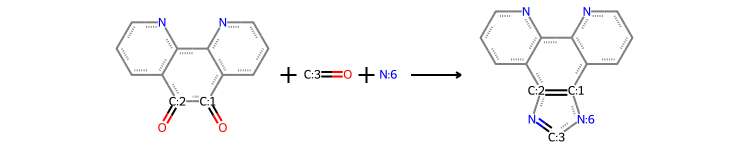

In [47]:
reaction_smarts = 'O=[C:1]1c2cccnc2c3c(cccn3)[C:2]1=O.[C:3]=O.[NH2:6]>>[N:6]1[C:3]=N[C:2]2=[C:1]1c(cccn3)c3c4ncccc42'
reaction = AllChem.ReactionFromSmarts(reaction_smarts)
reaction

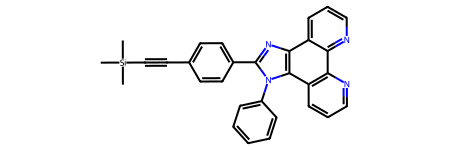

In [48]:
reactants = (Chem.MolFromSmiles('O=C1C2=CC=CN=C2C3=C(C=CC=N3)C1=O'), Chem.MolFromSmiles("C[Si](C)(C)C#CC1=CC=C(C=C1)C=O"), Chem.MolFromSmiles("NC1=CC=CC=C1"))
product_sets = reaction.RunReactants(reactants)
product_sets[1][0]

In [49]:
phenanthroline_dione = Chem.MolFromSmiles('O=c1c2cccnc2c3c(cccn3)c1=O')

# Génération des produits
products = []
for aldehyde in aldehydes.SMILES:
    for amine in amines.SMILES:
        reactants = (phenanthroline_dione, Chem.MolFromSmiles(aldehyde), Chem.MolFromSmiles(amine))
        product_sets = reaction.RunReactants(reactants)
        for product in product_sets:
            products.append(product[0]) 

# Affichage des produits générés
mols2grid.display(products, molsPerRow=2, subImgSize=(300, 300))


In [31]:
smiles=[]
i=0
for mol in products:
    try:
        Chem.SanitizeMol(mol)
        smiles.append(Chem.MolToSmiles(mol))
    except:
        print(f'Sanitization failed for molecule {i}.')
    i+=1
len(smiles)

Sanitization failed for molecule 324.
Sanitization failed for molecule 326.
Sanitization failed for molecule 328.
Sanitization failed for molecule 329.
Sanitization failed for molecule 332.
Sanitization failed for molecule 333.
Sanitization failed for molecule 336.
Sanitization failed for molecule 338.
Sanitization failed for molecule 340.
Sanitization failed for molecule 342.
Sanitization failed for molecule 344.
Sanitization failed for molecule 346.
Sanitization failed for molecule 348.
Sanitization failed for molecule 350.
Sanitization failed for molecule 352.
Sanitization failed for molecule 354.
Sanitization failed for molecule 356.
Sanitization failed for molecule 358.
Sanitization failed for molecule 360.
Sanitization failed for molecule 362.
Sanitization failed for molecule 364.
Sanitization failed for molecule 366.
Sanitization failed for molecule 368.
Sanitization failed for molecule 370.
Sanitization failed for molecule 372.
Sanitization failed for molecule 374.
Sanitization

468

In [33]:
unique=[]
for smi in smiles:
    if smi not in unique:
        unique.append(smi)
len(unique)

234

In [34]:
ligands=pd.DataFrame()
ligands['SMILES'] = pd.DataFrame(unique)

In [35]:
mols2grid.display(ligands, size=(200,200))

MolGridWidget()

In [36]:
ligands['mol'] = ligands['SMILES'].apply(Chem.MolFromSmiles)

In [37]:
top6 = ['c1ccc(-c2ccccn2)nc1', 'c1cnc2c(c1)ccc1cccnc12', 'Cc1ccc2ccc3ccc(C)nc3c2n1', 'c1ccc(-c2ccnc3c2ccc2c(-c4ccccc4)ccnc23)cc1',
        'Cc1ccnc(-c2cc(C)ccn2)c1', 'c1ccc2nc3c4cccnc4c4ncccc4c3nc2c1']
A_lig = pd.DataFrame(columns=['SMILES'])
A_lig.SMILES = top6

ligands_AAB=[]
for A in top6:
    for B in ligands.SMILES:
        ligands_AAB.append({'L1' : A, 'L2' : A, 'L3' : B}) #two generic phen- or bipy-based ligands + 1 specific ligand
print(len(ligands_AAB))

ligands_AAB = pd.DataFrame(ligands_AAB)
ligands_AAB.to_csv('library_thiopyr.csv', index = False)

1404


## Generating thiourea ligands

In [7]:
amines = pd.read_csv('./data/lab_reagents/amines_sec_smiles.csv')
acyl_cl = pd.read_csv('./data/lab_reagents/acyl_cl_smiles.csv')

In [8]:
amines['mol'] = amines['SMILES'].apply(Chem.MolFromSmiles)
acyl_cl['mol'] = acyl_cl['SMILES'].apply(Chem.MolFromSmiles)

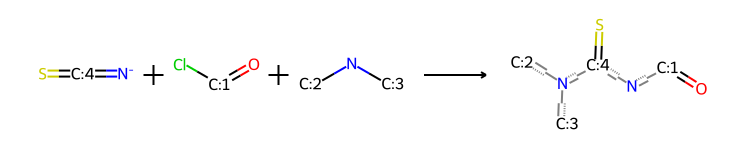

In [23]:
reaction_smarts = 'S=[C:4]=[N-].[C:1](-Cl)=O.[C:2]-N-[C:3]>>[C:1](N[C:4](N([C:2])[C:3])=S)=O'
reaction = AllChem.ReactionFromSmarts(reaction_smarts)
reaction

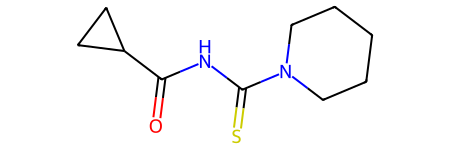

In [24]:
reactants = (Chem.MolFromSmiles('S=C=[N-]'), Chem.MolFromSmiles("C1CC1C(=O)Cl"), Chem.MolFromSmiles("C1CCNCC1"))
product_sets = reaction.RunReactants(reactants)
product_sets[1][0]

In [25]:
thiocyanate = Chem.MolFromSmiles('S=C=[N-]')

# Génération des produits
products = []
for acyl_cl in acyl_cl.SMILES:
    for amine in amines.SMILES:
        reactants = (thiocyanate, Chem.MolFromSmiles(acyl_cl), Chem.MolFromSmiles(amine))
        product_sets = reaction.RunReactants(reactants)
        for product in product_sets:
            products.append(product[0]) 

# Affichage des produits générés
mols2grid.display(products, molsPerRow=2, subImgSize=(300, 300))


MolGridWidget()

In [26]:
smiles=[]
i=0
for mol in products:
    try:
        Chem.SanitizeMol(mol)
        smiles.append(Chem.MolToSmiles(mol))
    except:
        print(f'Sanitization failed for molecule {i}.')
    i+=1
len(smiles)

384

In [27]:
unique=[]
for smi in smiles:
    if smi not in unique:
        unique.append(smi)
len(unique)

120

In [28]:
ligands=pd.DataFrame()
ligands['SMILES'] = pd.DataFrame(unique)
mols2grid.display(ligands, size=(200,200))

MolGridWidget()

In [29]:
ligands['mol'] = ligands['SMILES'].apply(Chem.MolFromSmiles)

In [34]:
top5 = ['c1ccc(-c2ccccn2)nc1', 'c1cnc2c(c1)ccc1cccnc12', 'c1ccc(-c2ccnc3c2ccc2c(-c4ccccc4)ccnc23)cc1',
        'Cc1ccnc(-c2cc(C)ccn2)c1', 'c1ccc2nc3c4cccnc4c4ncccc4c3nc2c1']
A_lig = pd.DataFrame(columns=['SMILES'])
A_lig.SMILES = top5

ligands_AAB=[]
for A in top5:
    for B in ligands.SMILES:
        ligands_AAB.append({'L1' : A, 'L2' : A, 'L3' : B}) #two generic phen- or bipy-based ligands + 1 specific ligand
print(len(ligands_AAB))

ligands_AAB = pd.DataFrame(ligands_AAB)

ligands_AAB['SMILES'] = ligands_AAB['L1']+'.'+ligands_AAB['L2']+'.'+ligands_AAB['L3']
mols2grid.display(ligands_AAB, size=(200,200))

600


MolGridWidget()

In [35]:
ligands_AAB.to_csv('library_thiourea_quartzy.csv', index = False)